# Applications of Classification

In this lab you will perform **two-class classification** using **logistic regression**. A classifier is a machine learning model that separates the **label** into categories or **classes**. In other words, classification models are **supervised** machine learning modules which predict a categorical label

In this case, bank customer data is used to determine if a particular person is a good or bad credit risk. Thus, credit risk of the customer is the classes you must predict. In this case, the cost to the bank of issuing a loan to a bad risk customer is five times that of denying a loan to a good customer. This fact will become important when evaluating the performance of the model. 

Logistic regression is a linear model but with a nonlinear response. The response is binary, $\{ 0,1 \}$, or positive and negative. The response is the prediction of the category. 

In this lab you will learn the following: 
-  How to prepare data for classification models using tools in R, in particular the Caret package. 
-  Constructing a classification model with R.
-  Evaluating the performance of the classification model. 
-  Using techniques such as reweighting the labels and changing the decision threshold to change the trade-off between false positive and false negative error rates. 

## Basics of logistic regression

In this section some basic properties of the logistic regression model are presented. 

First, execute the code in the cell below to load the packages required  to run this notebook. 

In [2]:
## Import packages
library(ggplot2)
library(repr)
library(caret)
library(ROCR)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions

Loading required package: lattice
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response, `{False, True}` or `{0, 1}`. You can think of this response as having a Binomial distribution. For linear regression the response is just, well, linear. Logistic regression is a linear regression model with a nonlinear output. The response of the linear model is transformed or 'squashed' to values close to 0 or 1 using a **sigmoidal function**, also known as the **logistic function**. The result of this transformation is a response which is the log likelihood for each of the two classes. 

The sigmoidal or logistic function can be expressed as follows:

$$f(x) = \frac{1}{1 + e^{-\kappa(x - x_0)}} \\
\kappa = steepness$$

Execute the code in the cell below to compute and plot an example of the logistic function.

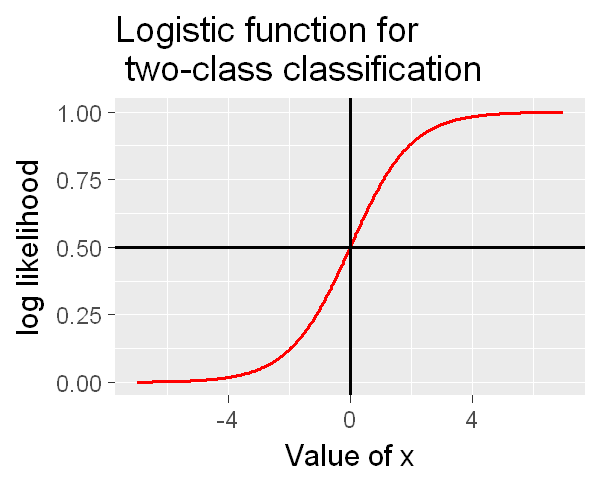

In [3]:
xseq = seq(-7, 7, length.out = 500)
plot.logistic = function(v){
  options(repr.plot.width=5, repr.plot.height=4)
  logistic = exp(xseq - v)/(1 + exp(xseq - v))
  df = data.frame(x = xseq, y = logistic)
  ggplot(df, aes(x,y)) +
    geom_line(size = 1, color = 'red') +
    geom_vline(xintercept = v, size = 1, color = 'black') +
    geom_hline(yintercept = 0.5, size = 1, color = 'black') +
    ylab('log likelihood') + xlab('Value of x') +
    ggtitle('Logistic function for \n two-class classification') +
    theme_grey(base_size = 18)
}
plot.logistic(0)

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{y} = \beta_0 + \beta_1\ x$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. Substituting the linear model into the logistic function creates the following expression:

$$F(\hat{y}) = \frac{1}{1 + e^{-\kappa(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continuous output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le F(\hat{y}) \le 1$.

## Load and prepare the data set

As a first step, load the dataset. The code in the cell below loads the dataset and displays the head of the data frame. Execute this code and examine the result.

In [4]:
credit = read.csv('German_Credit_Preped.csv')
dim(credit)
head(credit)

[1] 1000   22

Customer_ID,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,0
6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,1
2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,0
8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,0
3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,...,unknown-none,53,none,for free,2,skilled,2,none,yes,1
3115687,none,36,current loans paid,education,9055,unknown/none,1 - 4 years,2,male-single,...,unknown-none,35,none,for free,1,unskilled-resident,2,yes,yes,0


There are 20 features, the customer ID, and a label column. These features represent information a bank might have on its customers. 

The categorical features now have meaningful coding. Additionally the label is now coded as a binary variable.

## Investigate label imbalance

There is one other aspect of this data set which you should be aware of. The label has significant **class imbalance**. Class imbalance means that there are  unequal numbers of cases for the categories of the label. 

To examine the class imbalance in these data, execute the code in the cell below. 

In [5]:
table(credit[,'bad_credit'])


  0   1 
700 300 

Notice that only 30% of the cases have bad credit. This is not surprising, since a bank would typically retain customers with good credit. However, this imbalance will bias the training of any model. 

Before proceeding, answer **Question 1** on the course page.

## Code the positive and negative cases

The R Caret package computes most performance metrics using the positive cases. For example, recall is a measure of correct classification of positive cases. Therefore, it is important to have the coding of the label correct. In this case you want to detect bad credit customers, so this category becomes the positive case. The code in the cell below creates a factor (categorical) variable and coerces the levels of the label column, `bad_credit`. Execute this code. 

****
**Note:** Whenever you work with binary (two-class) classifier software it is important to be clear which case is positive and which is negative. In this case the levels of label are set in the code below. Confusion on this point can lead to 
****

In [6]:
credit$bad_credit <- ifelse(credit$bad_credit == 0, 'good', 'bad')
credit$bad_credit <- factor(credit$bad_credit, levels = c("bad", "good"))
credit$bad_credit[1:5]

[1] good bad  good good bad 
Levels: bad good

In the results above you can see the new coding of the label column along with the levels, {'bad', 'good'}. 

## Split the data

You must now create randomly sampled training and test data sets. The `createDataPartition` function from the R caret package is used  to create indices for the training data sample. In this case 70% of the data will be used  for training the model. Execute this code and note the dimensions of the resulting data frame. 

In [7]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(credit[,'bad_credit'], times = 1, p = 0.7, list = FALSE)
training = credit[partition,] # Create the training sample
dim(training)
test = credit[-partition,] # Create the test sample
dim(test)

[1] 700  22

[1] 300  22

## Scale numeric features

Scaling of numeric features is an important step when preparing data for training a machine learning model. The code in the cell below does the following:
1. Computes a caret package `preProcess` object for centering and scaling the data. Notice that these computations are done only with the training data. 
2. The transformations are applied to both the training and test dataset. 

Execute this code.

In [8]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'age_yrs')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,loan_duration_mo,loan_amount,payment_pcnt_income,age_yrs
1,-1.2111310,-0.7137211,0.91818241,2.6286850
3,-0.7100721,-0.3883552,-0.88723244,1.0922267
4,1.7952226,1.6424615,-0.88723244,0.7507916
5,0.2920458,0.5852856,0.01547498,1.4336619
7,0.2920458,-0.1289751,0.01547498,1.4336619
8,1.2941637,1.3146387,-0.88723244,-0.1027964


## Construct the logistic regression model

Now, it is time to compute the logistic regression model. The code in the cell below using the R generalized linear model or `glm` function to compute a model object as follows:
1. The formula for the label vs. the features is defined. 
2. Since this is logistic regression, the Binomial distribution is specified for the response.

Execute this code. 

In [9]:
set.seed(5566)
logistic_mod = glm(bad_credit ~ loan_duration_mo + loan_amount +  
                                payment_pcnt_income + age_yrs + 
                                checking_account_status + credit_history + 
                                purpose + gender_status + time_in_residence +
                                property, 
                   family = binomial, data = training)

Now, print and examine the model coefficients by executing the code in the cell below. 

In [10]:
logistic_mod$coefficients

(Intercept) 
                                          -0.75390333 
                                     loan_duration_mo 
                                          -0.35411346 
                                          loan_amount 
                                          -0.15046589 
                                  payment_pcnt_income 
                                          -0.30474847 
                                              age_yrs 
                                           0.22021622 
 checking_account_status> 200 DM or salary assignment 
                                           1.17710561 
                    checking_account_status0 - 200 DM 
                                           0.52879257 
                          checking_account_statusnone 
                                           1.85130662 
credit_historycritical account - other non-bank loans 
                                           1.43374851 
                     credit_historycurrent loans paid 
                                           0.97990665 
                       credit_historyno credit - paid 
                                          -0.13012144 
                    credit_historypast payment delays 
                                           0.82827210 
                                     purposecar (new) 
                                          -0.78850478 
                                    purposecar (used) 
                                           0.61501255 
                           purposedomestic appliances 
                                          -0.51539198 
                                     purposeeducation 
                                          -0.69523420 
                           purposefurniture/equipment 
                                          -0.15888329 
                                         purposeother 
                                           0.42870881 
                              purposeradio/television 
                                           0.13080063 
                                       purposerepairs 
                                          -0.71067719 
                                    purposeretraining 
                                           1.18608234 
                 gender_statusmale-divorced/separated 
                                          -0.15388454 
                    gender_statusmale-married/widowed 
                                           0.09341969 
                             gender_statusmale-single 
                                           0.48799863 
                                    time_in_residence 
                                          -0.04127121 
                                 propertycar or other 
                                          -0.06082133 
                                  propertyreal estate 
                                           0.28711696 
                                 propertyunknown-none 
                                          -0.46401973

First of all, notice that model coefficients are similar to what you might expect for an linear regression model. As previously explained the logistic regression is indeed a linear model.  

Recall that the logistic regression model outputs log likelihoods. The class with the highest probability is taken as the score (prediction). Execute the code and the cell below to compute and display a sample of these class probabilities for the test feature set. 

In [11]:
test$probs = predict(logistic_mod, newdata = test, type = 'response')
test[1:20, c('bad_credit','probs')]

,bad_credit,probs
2,bad,0.5337613
6,good,0.6729046
17,good,0.9506619
21,good,0.9123956
24,good,0.9317374
27,good,0.7881552
28,good,0.7721530
30,bad,0.2833987
32,good,0.5896523
33,good,0.5982149


The first column is the label and the second is the log likelihood of a positive score. Notice that several of these log likelihoods are close to 0.5. 

## Score and evaluate the classification model

Now that the log likelihoods have been computed these values must be transformed into actual class scores. Recall that the log likelihoods for two-class logistic regression are computed by applying the sigmoid or logistic transformation to the output of the linear model. The simple choice is to set the threshold between the two likelihoods at $0.5$. The code in the cell below applies this initial threshold to the probability of a score of $1$ for the test data. A few examples along with the known labels are then displayed. Execute this code and examine the result.

In [12]:
score_model = function(df, threshold){
    df$score = ifelse(df$probs < threshold, 1, 0)
    df
}

test = score_model(test, 0.5)
test[1:20, c('bad_credit','score')]

,bad_credit,score
2,bad,0
6,good,0
17,good,0
21,good,0
24,good,0
27,good,0
28,good,0
30,bad,1
32,good,0
33,good,0


Some of the positive ($1$) predictions agree with the test labels in the second row, but several do not.

Given the results of the test data, how can you quantify the performance of the model? In general, you must **always use multiple metrics to evaluate the performance of any machine leaning model**, including classifiers. 

For classifiers there are a number of metrics commonly used. The **confusion matrix** lays out the correctly and incorrectly classified cases in a tabular format. There are various metrics derived from the values in the confusion matrix. Some of the common cases are briefly reviewed below. 

**Confusion matrix**

As already stated, the confusion matrix lays out correctly and incorrectly classified cases. For the binary (two-class) case the confusion matrix is organized as follows:

| | Scored Positive | Scored Negative|  
|------|:------:|:------:| 
|**Actual Positive** | True Positive | False Negative |
|**Actual Negative**| False Positive | True Negative |   

Here the four elements in the matrix are defined as:    
**True Positive** or **TP** are cases with positive labels which have been correctly classified as positive.     
**True Negative** or **TN** are cases with negative labels which have been correctly classified as negative.  
**False Positive** or **FP** are cases with negative labels which have been incorrectly classified as positive.   
**False Negative** or **FN** are cases with positive labels which have been incorrectly classified as negative.

When creating a confusion matrix it is important to understand and maintain a convention for which differentiating positive and negative label values. The usual convention is to call the $1$ case positive and the $0$ case negative. 

Notice that there is an ambiguity in which case is considered positive and which is considered negative when the confusion matrix is computed. Whenever you examine a confusion matrix it is a good idea to spend a moment and decide which case is which. This step will help you relate the results to the problem at hand. 

**Accuracy**

Accuracy is a simple and often misused metric. In simple terms, accuracy is the fraction of cases correctly classified. For a two-class classifier accuracy is written as:

$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$

Accuracy can be quite misleading. For example, say a classifier is used to detect fraudulent accounts and the rate of fraud is less than 1%. A naive model would be to say all accounts are not fraudulent. This model has accuracy exceeding  0.99. This sounds impressive, but is clearly useless. 

**Precision**

Precision is the fraction of correctly classified label cases out of all cases classified with that label value. We can express precision by the following relationship:

$$Precision = \frac{M_{i,i}}{\sum_j M_{i,j}}$$

For example, the precision statistic is the number of correctly classified positive cases for the label value divided by all the cases in the column. 

**Recall**  

Recall or **sensitivity** is the fraction of cases of a label value correctly classified out of all cases that actually have that label value. We can express recall by the following relationship:

$$Recall = \frac{M_{i,i}}{\sum_i M_{i,j}}$$

For example, the recall statistic is the number of correctly classified positive cases for the label value divided by all the cases in the row. In this example recall is the **True Positive Rate**. Thus, recall is sensitive to the number of cases correctly classified for a given true label value. 

**Specificity**

Specificity or **True Negative Rate** is fraction of negative cases correctly classified. For the case of a binary classifier, specificity is given as:

$$Specificity = \frac{TN}{(TN + FP)}$$

**F1**

The F1 statistic is weighted average of precision and recall. We can express F1 by the following relationship:

$$F1 = 2 * \frac{precision * recall}{precision + recall}$$

In other words, F1 is a weighted metric for overall model performance. 

**ROC** and **AUC**

The receiver operating characteristic or ROC is a curve that displays the relationship between the true positive rate on the vertical axis and false positive rate on the horizontal axis. The ROC curve shows the tradeoff between true positive rate and false positive rate. An example is illustrated below.   

In principle, you can pick the desired operating point for a classifier on this curve. Towards the left favors low false positive rate at the expense of true positive rate. Towards the right favors high true positive rate at the expense of higher false positive rate.  

<img src="img/ROC_AUC.JPG" alt="Drawing" style="width:600px; height:400px"/>
<center>**ROC curve with values of AUC for balanced two-class problem**</center>

The AUC is the area or integral under the ROC curve. The overall performance of the classifier is measured by the area under the curve or AUC. But, how can you interpret a specific AUC value? The higher the AUC the lower the increase in false positive rate required to achieve a required true positive rate.  For an ideal classifier the AUC is 1.0. A true positive rate is achieved with a 0 false positive rate. This behavior means that AUC is useful for comparing classifiers. The classifier with higher AUC is generally the better one. 

****
**Note:** As defined above, AUC is the area under a curve of recall or true positive rate vs. (1-specificity) or false positive rate. It is also possible to create a version of the ROC curve of recall vs. precision. In some cases the R Caret package uses this alternative. Some care is require in determining which case is being reported.
****

For balanced cases, random guessing gives an AUC or 0.5. A balanced case has equal numbers of positive and negative cases. So Bernoulli sampling (random guessing) with a probability $p$ for the positive case, will produce a ROC curve that runs diagonally from $0.0,0.0$ to $1.0,1.0$. The area under this triangular region is 0.5. It is often said that a classifier with an AUC of greater than 0.5 is better than random guessing. But, **for unbalanced cases this statement is not in true in general**. 

****
**Note:** The term receive operating characteristic may seem a bit odd in the machine learning context. This term arose in the early days of radar engineering as a metric to measure the tradeoff between radar signal receiver correctly detecting a target, say an aircraft, and producing a positive response from noise, such as flying birds or clouds. A radar receiver would be adjusted to the desired operating point along its ROC curve. 
****

The code in the cell below implements a function that computes a confusion matrix. The confusion matrix is then used to compute the performance metrics. Execute this code and examine the results for the logistic regression model. 

In [13]:
logistic.eval <- function(df){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf = ifelse(df$bad_credit == 'bad' & df$score == 1, 'TP',
                    ifelse(df$bad_credit == 'bad' & df$score == 0, 'FN',
                           ifelse(df$bad_credit == 'good' & df$score == 0, 'TN', 'FP')))

  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
  
  ## Confusion matrix as data frame
  out = data.frame(Negative = c(TN, FN), Positive = c(FP, TP))
  row.names(out) = c('Actual Negative', 'Actual Positive')
  print(out)  
  
  # Compute and print metrics
  P = TP/(TP + FP)
  R = TP/(TP + FN)  
  F1 = 2*P*R/(P+R)  
  cat('\n')
  cat(paste('accuracy  =', as.character(round((TP + TN)/(TP + TN + FP + FN), 3)), '\n'))      
  cat(paste('precision =', as.character(round(P, 3)), '\n'))     
  cat(paste('recall    =', as.character(round(R, 3)), '\n'))
  cat(paste('F1        =', as.character(round(F1,3)),'\n'))
}
logistic.eval(test)

                Negative Positive
Actual Negative      191       19
Actual Positive       51       39

accuracy  = 0.767 
precision = 0.672 
recall    = 0.433 
F1        = 0.527 


Examine these results:
1. The confusion matrix shows the following characteristics; a) most of the positive cases are correctly classified, 183 vs. 25, however, b) most negative cases are are scored incorrectly, only 35 correct, vs. 57 incorrect.   
2. The overall accuracy is 0.7t. However as just observed this is **extremely misleading!**. In fact the negative cases are poorly classified, and it is these bad credit customers the bank cares most about. This is not an unusually case. Accuracy figures should always be regarded with healthy skepticism.
3. The class imbalance is confirmed. Of the 300 test cases, the majority are positive and a minority are negative. 
4. The accuracy, precision, recall and F1 all show that negative cases are classified reasonably well, but the positive cases are not. As already mentioned, it is these positive cases that are of greatest importance to the bank. 

Finally, the code in the cell below uses the `prediction` and `performance` functions from the ROCR package to compute and display the ROC curve and AUC. The ROCR package creates R S4 objects. The values in these objects are accessed from slots. 

Execute this code, examine the result, and answer **Question 2** on the course page.

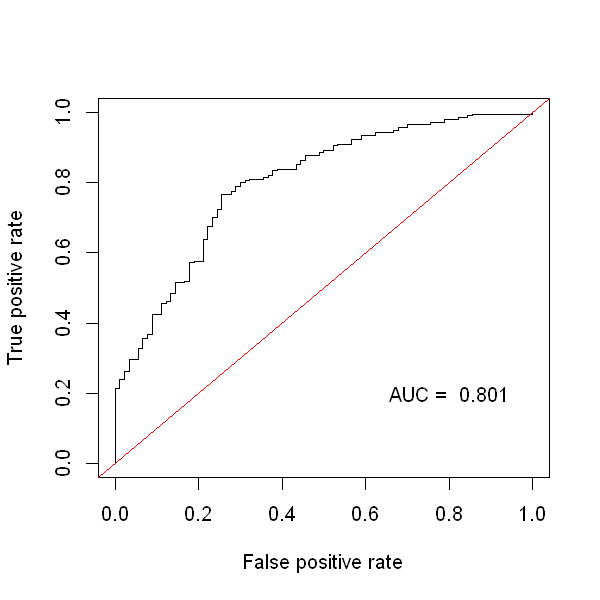

In [14]:
ROC_AUC = function(df){
    options(repr.plot.width=5, repr.plot.height=5)
    pred_obj = prediction(df$probs, df$bad_credit)
    perf_obj <- performance(pred_obj, measure = "tpr", x.measure = "fpr")
    AUC = performance(pred_obj,"auc")@y.values[[1]] # Access the AUC from the slot of the S4 object
    plot(perf_obj)
    abline(a=0, b= 1, col = 'red')
    text(0.8, 0.2, paste('AUC = ', as.character(round(AUC, 3))))
}

ROC_AUC(test)

The ROC curve is above the diagonal red line and the AUC is 0.8. But, given the class imbalance of two positive cases for each negative case how good is this? 

One point of comparison is a naive 'classifier' that sets all cases to positive. The code in the cell below contains such a classifier. This algorithm is not really a classifier at all. This 'classifier' is hard coded. The ROC curve and AUC are then computed and displayed. Run this code, and examine the result. 

                Negative Positive
Actual Negative      210        0
Actual Positive       90        0

accuracy  = 0.7 
precision = NaN 
recall    = 0 
F1        = NaN 


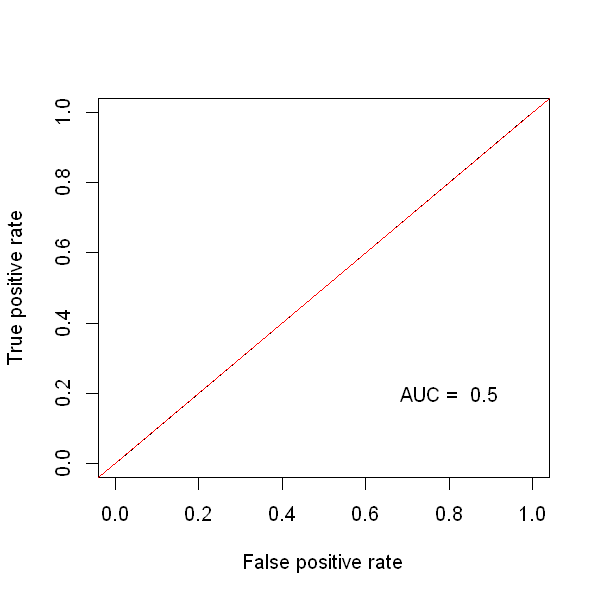

In [15]:
test$probs = rep(0, lenght.out = nrow(test))
test$score = rep(0, lenght.out = nrow(test))
logistic.eval(test)
ROC_AUC(test)

Notice, the accuracy from this 'classifier' is 0.7. This reflects the class imbalance and should be a warning not to trust any one metric! The ROC curve is directly along the diagonal which gives an AUC of about 0.5. The logistic regression classifier is definitely better than this!

## Compute a weighted model

Recall that a falsely classifying a bad credit risk customer as good costs the bank five times more than classifying a good credit risk customer as bad. Further, there is significant class imbalance. Given this situation, the results of the first model are not that good. There are two reasons for this:

1. The class imbalance in the label has biased the training of the model. As you observed from the accuracy of the naive 'classifier' is not that different from the logistic regression model. 
2. Nothing has been done to weight the results toward correctly classifying the bad credit risk customers at the expense of the good credit risk customers.

One approach to these problems is to weight the classes when computing the logistic regression model. The code in the cell below uses a vector that weights each of the training cases. Notice that a 'quasibinomial' distribution is used for the response. The quasibinomial distribution is more robust to a large dispersion in predictions, and is more stable computationally. Execute this code.

In [16]:
## Create a weight vector for the training cases.
weights = ifelse(training$bad_credit == 'bad', 0.66, 0.34)
## GLM with weights
logistic_mod_w = glm(bad_credit ~ loan_duration_mo + loan_amount +  
                                  payment_pcnt_income + age_yrs + 
                                  checking_account_status + credit_history + 
                                  purpose + gender_status + time_in_residence +
                                  property, 
                     family = quasibinomial, data = training,
                     weights = weights)

Next, execute the code in the cell below to compute and display the class probabilities for each case. 

In [17]:
test$probs = predict(logistic_mod_w, newdata = test, type = 'response')
test[1:20, c('bad_credit','probs')]

,bad_credit,probs
2,bad,0.3731437
6,good,0.4849324
17,good,0.9131080
21,good,0.8492696
24,good,0.8828502
27,good,0.6854614
28,good,0.6201342
30,bad,0.1640578
32,good,0.4095292
33,good,0.4228194


By eyeball, the above probabilities are not terribly different from the unweighted model. 

To find if there is any significant difference with the unweighted model, compute the scores and .the metrics and display the metrics by executing the code in the cell below.

Then, answer **Question 3** on the course page.

                Negative Positive
Actual Negative      168       42
Actual Positive       27       63

accuracy  = 0.77 
precision = 0.6 
recall    = 0.7 
F1        = 0.646 


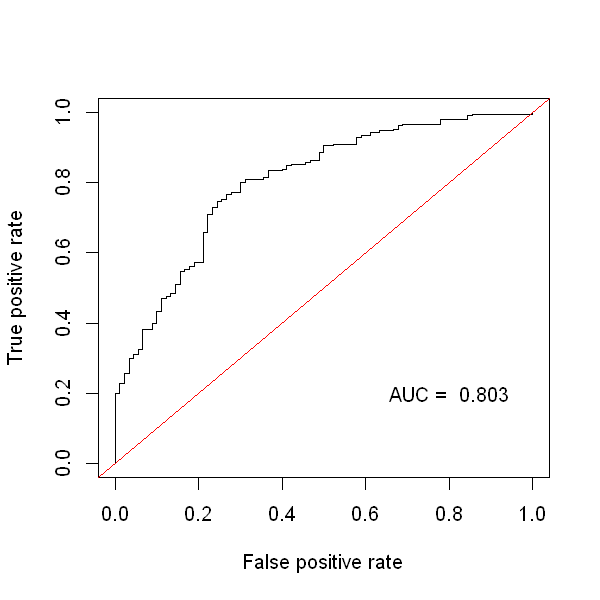

In [18]:
test = score_model(test, 0.5)
logistic.eval(test)
ROC_AUC(test)

The F1 and recall have increased at the expense of accuracy and precision. The AUC is unchanged. Re-weighting the labels has moved the results in the desired direction, at least a bit.

Notice also, the ROC curve and AUC are essentially unchanged. The trade-off between true positive and false positive is similar to the unweighted model.

## Find a better threshold

There is another way to tip the model scoring toward correctly identifying the bad credit cases. The scoring threshold can be adjusted. Until now, the scores have been computed from the probabilities using a threshold of 0.5. However, there is no reason to think this is the correct choice. Recall that the score is  determined by setting the threshold along the sigmoidal or logistic function. It is possible to favor either positive or negative cases by changing the threshold along this curve. 

The code in the cell below contains a function for scoring and evaluating the model for a given threshold value. The `for` loop iterates over the list of five candidate threshold values. Execute this code and examine how changing the threshold value changes the scoring for the model. 

In [19]:
test_threshold = function(test, threshold){
    test$score = predict(logistic_mod_w, newdata = test, type = 'response')
    test = score_model(test, t)
    cat('\n')
    cat(paste('For threshold = ', as.character(threshold), '\n'))
    logistic.eval(test)
}

thresholds = c(0.5, 0.55, 0.60, 0.65)
for(t in thresholds) test_threshold(test, t) # Iterate over the thresholds


For threshold =  0.5 
                Negative Positive
Actual Negative      168       42
Actual Positive       27       63

accuracy  = 0.77 
precision = 0.6 
recall    = 0.7 
F1        = 0.646 

For threshold =  0.55 
                Negative Positive
Actual Negative      161       49
Actual Positive       25       65

accuracy  = 0.753 
precision = 0.57 
recall    = 0.722 
F1        = 0.637 

For threshold =  0.6 
                Negative Positive
Actual Negative      149       61
Actual Positive       20       70

accuracy  = 0.73 
precision = 0.534 
recall    = 0.778 
F1        = 0.633 

For threshold =  0.65 
                Negative Positive
Actual Negative      131       79
Actual Positive       19       71

accuracy  = 0.673 
precision = 0.473 
recall    = 0.789 
F1        = 0.592 


As the threshold is decreased the number of correctly classified negative cases (bad credit customers) increases at the expense of correctly classifying positive cases (good credit customers). At the same time, accuracy decreases. However, as you have observed, accuracy is not a particularly useful metric here. 

Exactly which threshold to pick is a business decision. Notice that with a threshold value of 0.6 the number of false negatives (misclassified good credit customers) is more than three times that of false positives (misclassified bad credit customers), but at a cost of a high false positive rate. 

## Summary

In this lesson you have done the following:
1. Prepared the credit risk data set for modeling. The steps included coding the label and scaling the numeric features. 
2. Computed a logistic regression model. 
3. Evaluated the performance of the module using multiple metrics. It is clear that accuracy is not a particularly useful metric here. The naive 'classifier' produced accuracy that was only somewhat worse as a result of the class imbalance.  The confusion matrix and the precision, recall and F1 statistics gave meaningful measures of model performance, especially when considered together. 
4. Re-weighted the labels and changed the decision threshold for the re-weighted model. These steps helped overcome both the class imbalance problem and the asymmetric cost of misclassification to the bank. 